In [14]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [15]:
# Carrega os dados
df_inf_eu = pd.read_csv(r'C:\Users\flari\!!Estudos Tech\2.(DSA)_Business_Analytics\14_Macroeconomico_Previsao_Inflacao\Project\EU_Inflation.csv',
                        sep = ';')

df_inf_eu['TIME_PERIOD'] = df_inf_eu['TIME_PERIOD'].str.replace('-', '').astype(int)
df_inf_eu = df_inf_eu[df_inf_eu['TIME_PERIOD'] >= 201401]
df_inf_eu

,DATAFLOW,LAST UPDATE,freq,unit,coicop,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
204,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,201401,0.9,NaN
205,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,201402,0.8,NaN
206,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,201403,0.6,NaN
207,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,201404,0.8,NaN
208,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,201405,0.6,NaN
...,...,...,...,...,...,...,...,...,...
326,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,202403,2.6,NaN
327,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,202404,2.6,NaN
328,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,202405,2.7,NaN
329,ESTAT:PRC_HICP_MANR(1.0),31/07/2024 11:00,M,RCH_A,CP00,EU,202406,2.6,NaN


In [16]:
# Define nossa série temporal
inflacao = df_inf_eu['OBS_VALUE'].values.reshape(-1, 1)

In [17]:
inflacao

array([[ 0.9],
       [ 0.8],
       [ 0.6],
       [ 0.8],
       [ 0.6],
       [ 0.7],
       [ 0.5],
       [ 0.5],
       [ 0.4],
       [ 0.5],
       [ 0.4],
       [-0.1],
       [-0.5],
       [-0.3],
       [-0.1],
       [ 0.1],
       [ 0.5],
       [ 0.3],
       [ 0.4],
       [ 0.3],
       [ 0.1],
       [ 0.2],
       [ 0.1],
       [ 0.2],
       [ 0.3],
       [-0.1],
       [ 0. ],
       [-0.2],
       [-0.1],
       [ 0.1],
       [ 0.2],
       [ 0.2],
       [ 0.4],
       [ 0.5],
       [ 0.6],
       [ 1.1],
       [ 1.7],
       [ 2. ],
       [ 1.7],
       [ 2. ],
       [ 1.6],
       [ 1.5],
       [ 1.5],
       [ 1.7],
       [ 1.8],
       [ 1.7],
       [ 1.8],
       [ 1.6],
       [ 1.6],
       [ 1.4],
       [ 1.6],
       [ 1.5],
       [ 2. ],
       [ 2.1],
       [ 2.2],
       [ 2.2],
       [ 2.2],
       [ 2.3],
       [ 2. ],
       [ 1.6],
       [ 1.5],
       [ 1.6],
       [ 1.6],
       [ 1.9],
       [ 1.6],
       [ 1.6],
       [ 1

In [18]:
# Função para criar o dataset para o modelo LSTM com look_back
# O parâmetro look_back define o número de passos no tempo que o modelo usará para fazer cada previsão
def func_cria_dataset(data, look_back = 1):

    # Inicializa duas listas vazias, X e Y, que conterão as sequências de entrada e saída, respectivamente
    X, Y = [], []
    
    # Itera pelo conjunto de dados menos o valor de look_back. Isso é feito para evitar índices fora dos limites do array
    for i in range(len(data) - look_back):
        
        # Coleta uma sequência de dados de tamanho look_back começando no índice i
        a = data[i:(i + look_back), 0]
        
        # Adiciona a sequência à lista X
        X.append(a)
        
        # Adiciona o valor imediatamente após a sequência de look_back à lista Y. Esse será nosso valor de saída (target).
        Y.append(data[i + look_back, 0])
    
    # Converte X e Y para arrays numpy para compatibilidade com a maioria das bibliotecas de aprendizado de máquina
    return np.array(X), np.array(Y)

In [19]:
# Dividimos os dados em treinamento e teste (respeitando a ordem cronológica dos dados)
indice = int(len(inflacao) * 0.8)
dados_treino, dados_teste = inflacao[0:indice, :], inflacao[indice:len(inflacao), :]

In [20]:
# Normaliza os dados (requerimento para redes neurais)
scaler = MinMaxScaler(feature_range = (0, 1))

In [21]:
# Treina e aplica o scaler em treino e somente aplica em teste
dados_treino_norm = scaler.fit_transform(dados_treino)
dados_teste_norm = scaler.transform(dados_teste)

In [22]:
# Criamos os datasets para o modelo LSTM
look_back = 3 #<- Número de meses que olho 'para trás' para treinar o modelo de previsão 
X_treino, y_treino = func_cria_dataset(dados_treino_norm, look_back)
X_teste, y_teste = func_cria_dataset(dados_teste_norm, look_back)

In [23]:
# Reshape dos dados para [samples, time steps, features]. Isso é um requerimento do modelo LSTM
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

# Construindo o modelo LSTM
modelo = tf.keras.models.Sequential([tf.keras.layers.LSTM(124, input_shape = (look_back, 1)),
                                     tf.keras.layers.Dense(1)])

# Compila o modelo
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

print("\nTreinamento do Modelo.\n")

# Treinamento do modelo
modelo.fit(X_treino, y_treino, epochs = 124, batch_size = 1, verbose = 1)

# Fazendo previsões com o modelo
previsao_treino = modelo.predict(X_treino)
previsao_teste = modelo.predict(X_teste)

# Transformar de volta para a escala original para calcular o erro
previsao_treino = scaler.inverse_transform(previsao_treino)
y_treino_rescaled = scaler.inverse_transform([y_treino])
previsao_teste = scaler.inverse_transform(previsao_teste)
y_teste_rescaled = scaler.inverse_transform([y_teste])

# Calcular o RMSE
train_score = np.sqrt(mean_squared_error(y_treino_rescaled[0], previsao_treino[:, 0]))
print(f"\nRMSE em Treino: {train_score:.2f}")

test_score = np.sqrt(mean_squared_error(y_teste_rescaled[0], previsao_teste[:, 0]))
print(f"RMSE em Teste: {test_score:.2f}")


Treinamento do Modelo.

Epoch 1/124


c:\Users\flari\anaconda3\envs\FlavioEnv1.0\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0144  
Epoch 2/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0028  
Epoch 3/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034
Epoch 4/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0023  
Epoch 5/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049
Epoch 6/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034    
Epoch 7/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019    
Epoch 8/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022   
Epoch 9/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020    
Epoch 10/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030    
Epoch 11/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023    
Epoch 12/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023   
Epoch 13/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0017  
Epoch 14/124
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020    
Epoch 15/124
98/98 ━━━━━━━━━━━━━━━━━━━━

In [24]:
# Ajustar os índices para dados originais e previsões a fim de entregar o resultado em formato de plot

# Cria um índice para os dados de treino originais, começando em 'look_back' e terminando em 'look_back + len(y_treino_rescaled[0])'.
# Este índice será utilizado para associar cada ponto de dado de treino ao seu TIME_PERIOD correspondente no DataFrame 'df_inf_eu'.
original_train_data_index = df_inf_eu['TIME_PERIOD'][look_back:look_back + len(y_treino_rescaled[0])]
original_train_data_index

207    201404
208    201405
209    201406
210    201407
211    201408
        ...  
300    202201
301    202202
302    202203
303    202204
304    202205
Name: TIME_PERIOD, Length: 98, dtype: int32

In [25]:
# Cria um índice para os dados de teste originais.
# Começa a partir do final dos dados de treino padronizados e vai até o final dos dados de teste padronizados.
# O '2 * look_back' é utilizado para ajustar o índice corretamente.
original_test_data_index = df_inf_eu['TIME_PERIOD'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back + len(y_teste_rescaled[0])]

# Cria um índice para os valores previstos em treino, começando em 'look_back' e terminando em 'look_back + len(previsao_treino)'.
# Este índice será utilizado para associar cada ponto previsto no conjunto de treino ao seu TIME_PERIOD correspondente no DataFrame 'df_inf_eu'.
predicted_train_data_index = df_inf_eu['TIME_PERIOD'][look_back:look_back + len(previsao_treino)]

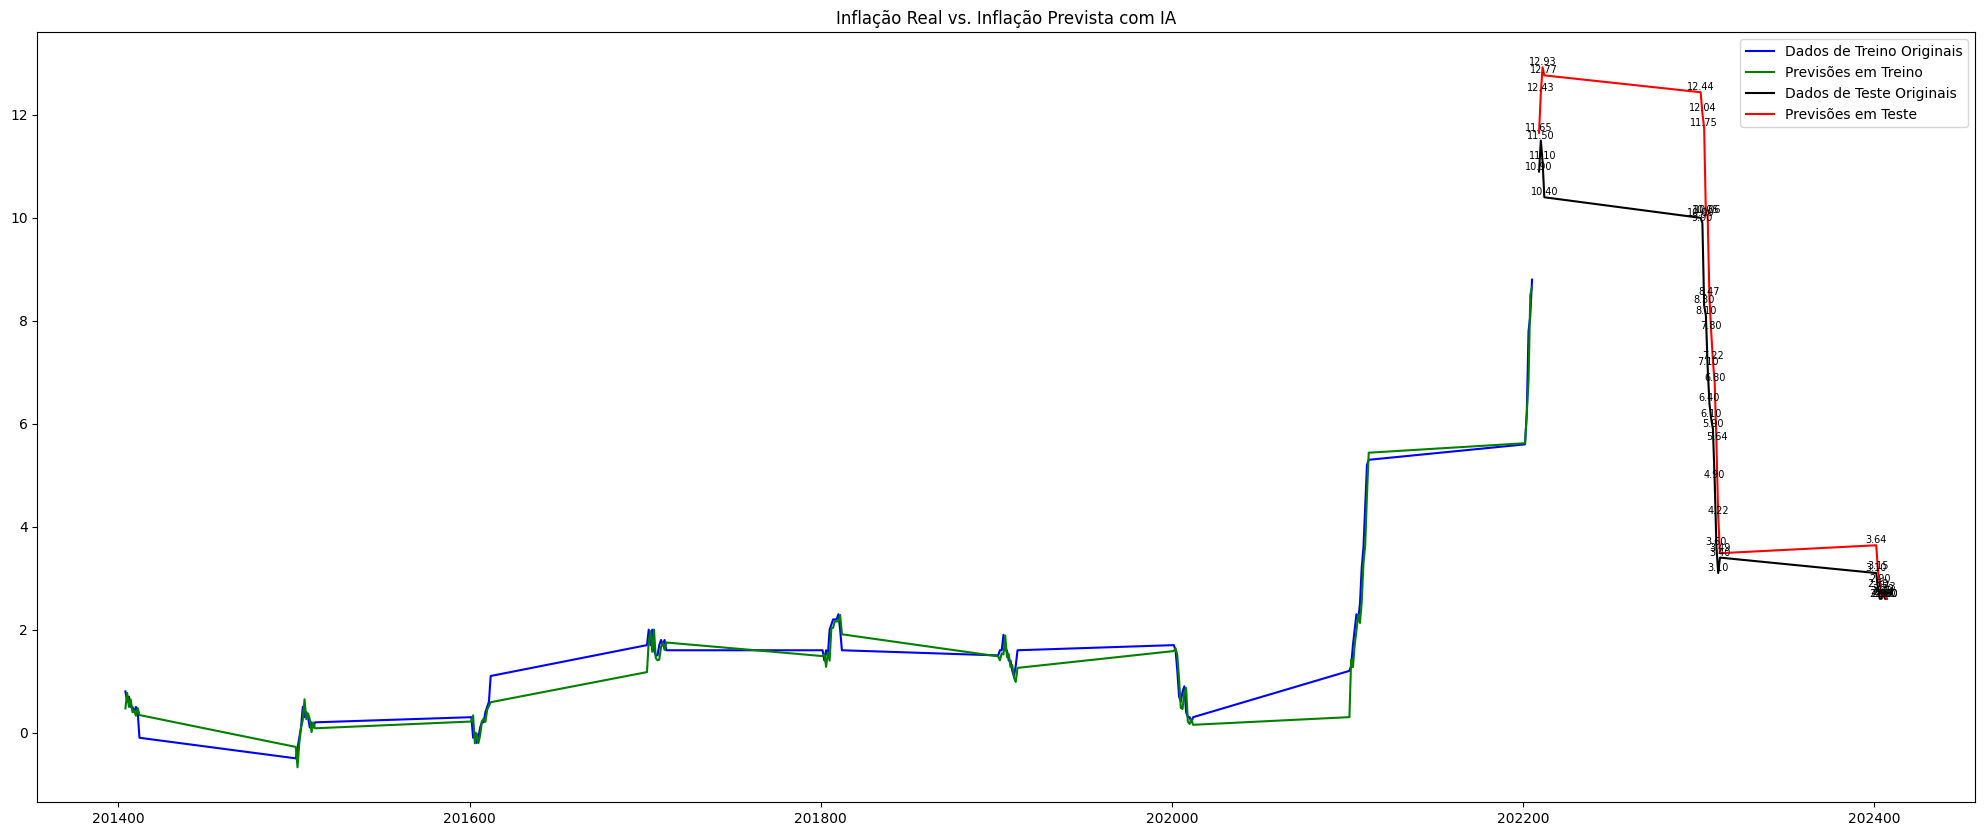

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Previsão da Inflação Para 2024.08: 2.6


C:\Users\flari\AppData\Local\Temp\ipykernel_9016\812594809.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_data[0, look_back - 1, 0] = prediction


In [26]:
# Cria um índice para os valores previstos em teste.
predicted_test_data_index = df_inf_eu['TIME_PERIOD'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back+len(previsao_teste)]

# Plotar os resultados
plt.figure(figsize = (25,10))

plt.plot(original_train_data_index, y_treino_rescaled[0], label = "Dados de Treino Originais", color = "blue")

plt.plot(predicted_train_data_index, previsao_treino[:, 0], label = "Previsões em Treino", color = "green")

plt.plot(original_test_data_index, y_teste_rescaled[0], label = "Dados de Teste Originais", color = "black")

for i, value in enumerate(y_teste_rescaled[0]):
    plt.annotate(f"{value:.2f}", (original_test_data_index.iloc[i], value), fontsize = 7, ha = 'center', va = 'bottom')

plt.plot(predicted_test_data_index, previsao_teste[:, 0], label = "Previsões em Teste", color = "red")

for i, value in enumerate(previsao_teste[:, 0]):
    plt.annotate(f"{value:.2f}", (predicted_test_data_index.iloc[i], value), fontsize = 7, ha = 'center', va = 'bottom')

plt.title("Inflação Real vs. Inflação Prevista com IA")
plt.legend()
plt.show()

# Previsões com o Modelo

# Usamos as últimas 3 entradas da série original de teste para fazer a próxima previsão
last_data = dados_teste_norm[-look_back:]
last_data = np.reshape(last_data, (1, look_back, 1))

# Lista
lista_previsoes = []

# Loop de Previsão para prever 2 TIME_PERIODs (2024.05 e 2025.06)
for _ in range(1):  

    # Previsão com o modelo (usamos os dados normalizados)
    prediction = modelo.predict(last_data)

    # Adiciona a previsão à lista de previsões
    lista_previsoes.append(prediction[0, 0])

    # Atualiza os dados para incluir a nova previsão e remover o valor mais antigo
    last_data = np.roll(last_data, shift = -1)
    last_data[0, look_back - 1, 0] = prediction

# Transformar de volta para a escala original
lista_previsoes_rescaled = scaler.inverse_transform(np.array(lista_previsoes).reshape(-1, 1))

print(f"\nPrevisão da Inflação Para 2024.08: {lista_previsoes_rescaled[0, 0]:.1f}")